# Predictive Analysis of S&P 500

**In this notebook, we applied Auto-Regressive models and Support Vector Machines to forecast future returns of S&P 500**

*Disclaimer: this was created on Google Colab and uploaded to GitHub as a Jupyter notebook*

## Data Preprocessing

####Settings
Initiate the lag and specify the feature we wish to extract from the dataset

- We take only the adjusted closing price as our feature; this way, we can account for any distributions and corporate actions that occurred at any time before the next day's opening price.

In [0]:
lag = 10
varid = "5. adjusted close"

####Installing Packages
The Alpha Vantage library is used to gather price data for different stock prices.

In [0]:
!pip install alpha_vantage

####Importing Libraries

In [0]:
# for data processing
import numpy as np 
import pandas as pd 
import io
from sklearn.model_selection import train_test_split
from alpha_vantage.timeseries import TimeSeries

# for datetime
from datetime import datetime
import time

# for models
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import classification_report
from scipy import stats

# for visualisations
import seaborn as sns
import matplotlib.pyplot as plt
import pandas.tools.plotting as ptp
from statsmodels.graphics.tsaplots import plot_acf

####Reading in Dataset
We choose the S&P 500 Index as the stock we want to do predictions on

In [0]:
ts = TimeSeries(key = "SSAQCES5CR00NXOY", output_format = "pandas", retries = lag)

data = ts.get_daily_adjusted(symbol = 'SPY', outputsize = 'full')
spy = data[0]

## Plots

####Plotting Return Distribution

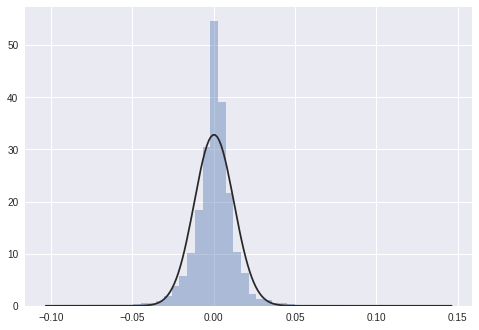

In [0]:
price = spy[varid]

returns = pd.DataFrame(price.pct_change())

returns = returns.fillna(0)

sns.set(color_codes=True)

sns.distplot(returns, kde=False, fit=stats.lognorm)

####Plot of Time Series Variables

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2a19d2e7f0>,
      dtype=object)

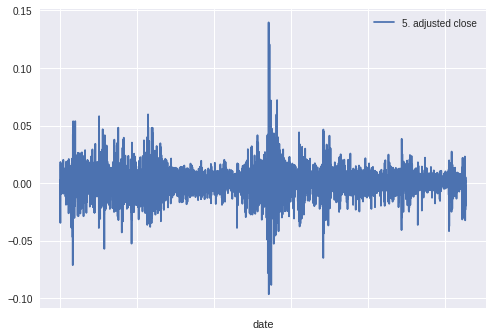

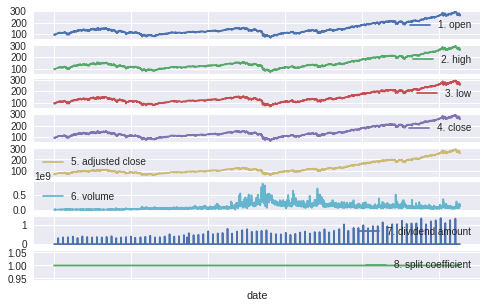

In [0]:
returns.plot()
spy.plot(subplots = True)

##Cross Correlation between Variables

In [0]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """

    return datax.corr(datay.shift(lag))
  


def autocross(datax, datay, lag=0):
    """
    Lag-N cross correlation

    Parameters
    ----------
    lag : int, default 0
    datax : DataFrame of variables to loop through
    datay : Pandas Series of variable to compare through

    Returns
    -------
    crosscorr : float
    """
    
    lagged = []
    
    if lag > len(datay):
      lag = len(datay) - 2
    
    if lag == 0:
      return "NA"
    else:
      correl = pd.DataFrame(np.NaN, index = datax.columns, columns = range(lag))
      
      for i in range(lag):
        lagged.append(datay.shift(i))
        
      for data in datax:
        for i in range(lag):
          correl.loc[data,i] = crosscorr(datax[data],datay, lag = i)
      
      
    return correl

##Correlation Lag Distribution of Time Series Variables

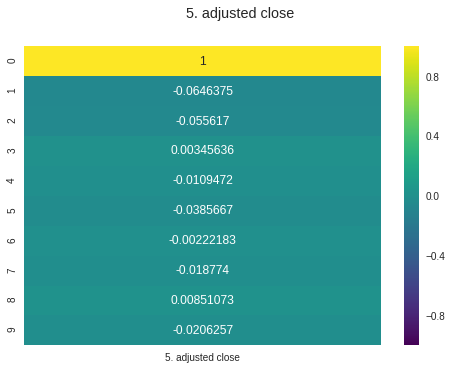

In [0]:
varlag = {}
fig = {}
lagid = {}

for data in returns:
  varlag[data] = autocross(returns, returns[varid], lag = lag)
  lagid[data] = varlag[data].idxmax(axis = 1)
  fig[data] = plt.figure(data)
  fig[data].suptitle(data)
  sns.heatmap(varlag[data].T, annot=True, fmt="g", cmap='viridis')
  plt.show()

##Auto-Correlation Analysis

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  


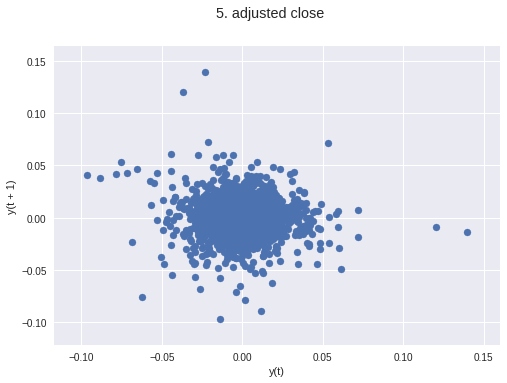

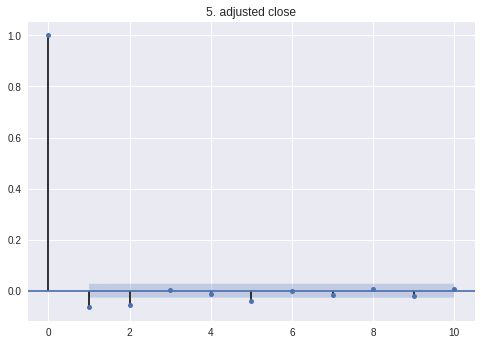

In [0]:
auto_corr = {}

for var in returns:
  auto_corr[var] = plt.figure(var)
  auto_corr[var].suptitle(var)
  ptp.lag_plot(returns[var])
  plt.show()
  plot_acf(returns[var], lags = lag, title = var)

##Dealing with Data

**Turning Timestamp into Features**
- Convert 'timestamp' from dataset into timestamp objects
- Create features from timestamp objects

In [0]:
spy.index = pd.to_datetime(spy.index)

date = spy.index
date_feature = pd.DataFrame({"year": date.year,
              "month": date.month,
              "day": date.day,
              "hour": date.hour,
              "dayofyear": date.dayofyear,
              "week": date.week,
              "weekofyear": date.weekofyear,
              "dayofweek": date.dayofweek,
              "weekday": date.weekday,
              "quarter": date.quarter,
             })

**Creating Binary Price Feature**

- We take only the adjusted closing price as our 'y'; this way, we can account for any distributions and corporate actions that occurred at any time before the next day's opening price.

- We derive the daily returns from prices

- The following code is to classify whether the return is negative or has no change (labelled '0') or positive ('1')

In [0]:
bina = returns.copy(deep = True)

bina[bina <= 0] = 0

bina[bina > 0] = 1

bina = bina.reset_index(drop=True)
bina.columns = ['y']

**Merging date_feature and price**

- These are the features we will be using for modelling; dates and binary prices

In [0]:
comb = pd.concat([date_feature, bina], axis=1)

comb = comb.dropna()

# creating x and y
x = comb.drop(columns = ['y'])
y = comb['y']


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

## Modelling

###Statsmodel Linear Regression - Ordinary Least Squares

Ordinary Least Squares (OLS) is a method for estimating the unknown parameters in a linear regression model.

In [0]:
# the model
spylm_model = sm.OLS(y_train, x_train).fit()

spylm_pred = spylm_model.predict(x_test)

print(spylm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     569.7
Date:                Tue, 18 Dec 2018   Prob (F-statistic):               0.00
Time:                        13:23:25   Log-Likelihood:                -2553.7
No. Observations:                3533   AIC:                             5121.
Df Residuals:                    3526   BIC:                             5165.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
day           -0.0018      0.011     -0.160      0.8

### SVM
Support Vector Machine (SVM) is a supervised machine learning algorithm that is used in this context for regression.

In [0]:
spyvm = SVC(kernel='linear').fit(x_train, y_train)

y_pred = spyvm.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       782
         1.0       0.55      1.00      0.71       959

   micro avg       0.55      0.55      0.55      1741
   macro avg       0.28      0.50      0.36      1741
weighted avg       0.30      0.55      0.39      1741



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
